In [1]:
import os
os.chdir('../2_modeling/')

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150
import seaborn as sns

from tqdm import tqdm
from discovery import CUCB, LLR, UCB1

# Parameters Setup

In [9]:
# Random seed for future replicability
np.random.seed(123)

# Number of places
M = 12
# Size of super-arms (o policías)
K = 2
# Horizont time
T_max = 1000

# Groud trurh: Expected value of crime by quadrant
mu_reales = np.random.randint(low = 4, high = 100, size = M)
# rho of binomial distribution such that rho = mu / N.
N = 1000
rho = mu_reales / N

# Underrporting param
q = np.random.uniform(size=M)

# Inicialize CUCB algorithm
cucb = CUCB(M, K, N, rho, q)

# Inicialize LLR algorithm
llr = LLR(M, K, N, q, rho, underreporting=False)

# Inicialize UCB1 algorithm
ucb1 =  UCB1(M, K, N, q, rho)

In [10]:
distances = pd.DataFrame(index=np.arange(T_max))
heat_map_a = pd.DataFrame(index=[f'Arm {i}' for i in range(M)])
paleta = sns.color_palette("Spectral_r", M)

# Run Algorithms

## Run CUCB

In [11]:
# Total number of times arm i is played so far
T_i = np.zeros(M)

# Mean outcomes
mu_hat = np.ones(M)

X_T = np.zeros((T_max, M))

S_T = np.zeros((T_max, M))

historical_mu_hat = np.zeros((T_max, M))

historical_mu_bar = np.zeros((T_max, M))
historical_q_hat =  np.zeros((T_max, M))
for t in range(T_max):
    t += 1

    # save historical mu_hat's
    historical_mu_hat[t - 1] = mu_hat
    q_temp = np.ma.array(X_T[:t], mask=S_T[:t].astype(bool)).mean(axis=0).data

    cond_temp = mu_hat == 0
    historical_q_hat[t - 1][cond_temp] = 0
    historical_q_hat[t - 1][~cond_temp] = q_temp[~cond_temp] / mu_hat[~cond_temp]

    # update rule
    mu_bar = cucb.update_rule(t, mu_hat, T_i)
    historical_mu_bar[t - 1] = mu_bar
    
    #oracle
    S = cucb.oracle(mu_bar)

    # 0-index
    S_T[t - 1] = S
    T_i[S.astype(bool)] += 1
    
    # update m_hat, t_i
    mu_hat = cucb.update_mu_hat_t_i(S, X_T, t, S_T)


distances['CUCB'] = np.linalg.norm(historical_mu_hat - np.tile(rho, (T_max, 1)), axis=1)    

heat_map_a['CUCB'] = T_i

### Figure 1 Section Model Validation.
CUCB Convergence to true arms mean.

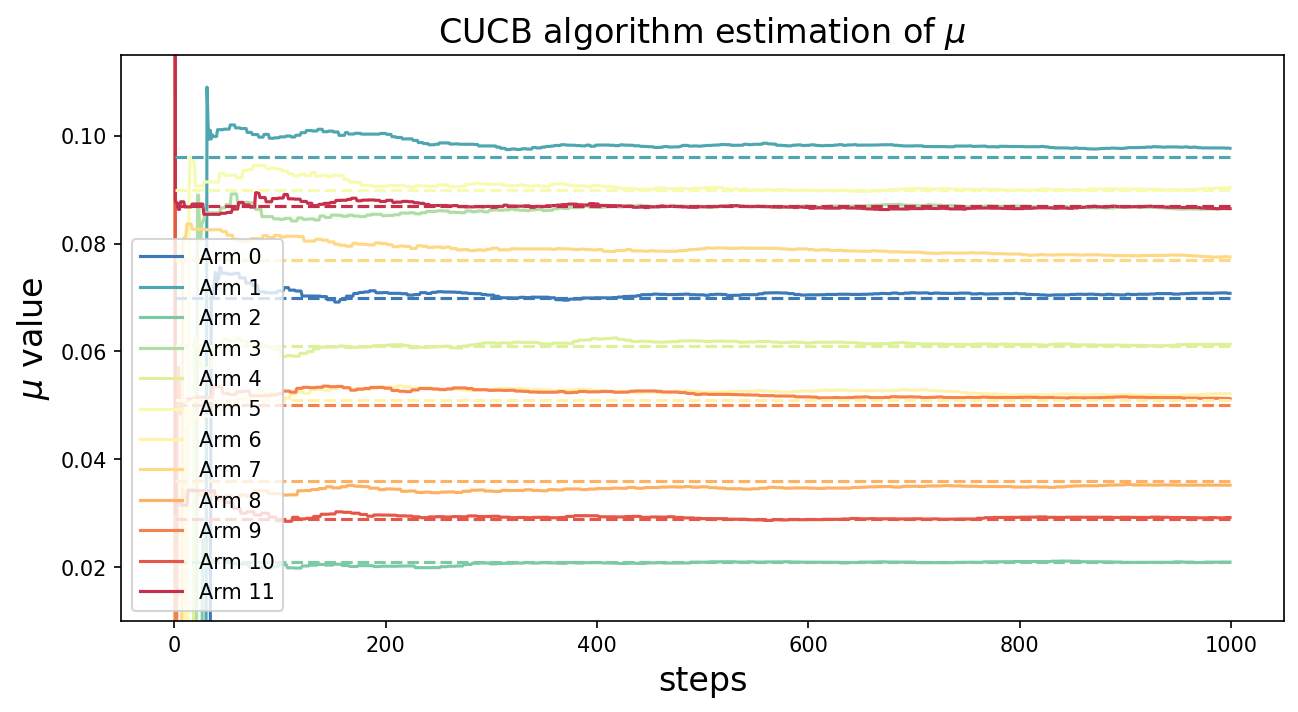

In [15]:
pd.DataFrame(historical_mu_hat, columns=[f'Arm {i}' for i in range(M)]).plot(figsize=(10, 5), ylim=(0.01,.115), color=paleta)
# Visualizamos las medias reales
for m, mu in enumerate(rho):
    plt.hlines(y = mu, xmin = 1, xmax = T_max, label = "Cuadrante " + str(m + 1), linestyles = "dashed", colors = paleta[m])

plt.title(r'CUCB algorithm estimation of $\mu$', fontsize=16)

plt.ylabel(r'$\mu$ value', fontsize=16);
plt.xlabel(r'steps',  fontsize=16);

plt.savefig(fname='../../Outputs/Figures/figure_1_model_validation.png')


### Figure 2 Section Model Validation.
CUCB Convergence to true arms underreporting parameters.

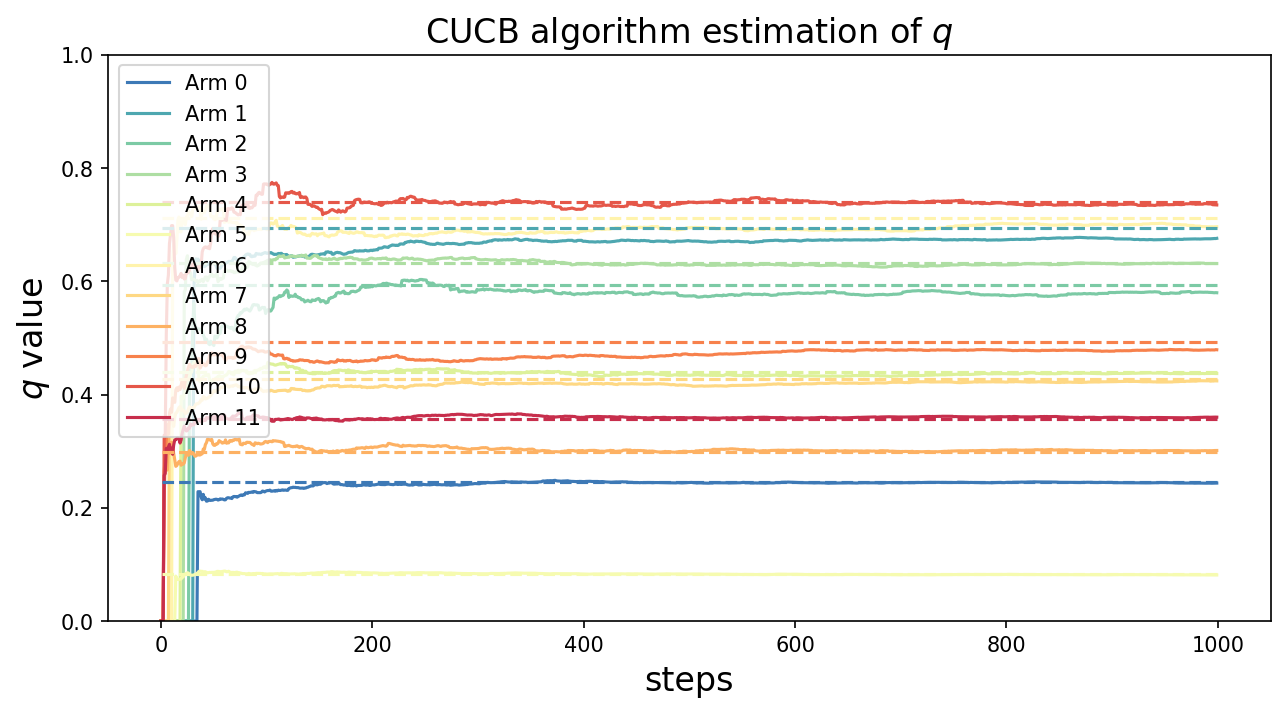

In [17]:
pd.DataFrame(historical_q_hat, columns=[f'Arm {i}' for i in range(M)]).plot(figsize=(10, 5), ylim=(0, 1), color=paleta)
# Visualizamos las medias reales
for m, mu in enumerate(q):
    plt.hlines(y = mu, xmin = 1, xmax = T_max, label = "Cuadrante " + str(m + 1), linestyles = "dashed", colors = paleta[m])

plt.title(r'CUCB algorithm estimation of $q$',  fontsize=16)

plt.ylabel(r'$q$ value', fontsize=16);
plt.xlabel(r'steps', fontsize=16);

plt.savefig(fname='../../Outputs/Figures/figure_2_model_validation.png')

## Run LLR

In [18]:
# Total number of times arm i is played so far
T_i = np.zeros(M)

# Mean outcomes

X_T = np.zeros((T_max, M))

S_T = np.zeros((T_max, M))

historical_mu_hat = np.zeros((T_max, M))

mu_hat = llr.initialization(T_i)

historical_q_hat =  np.zeros((T_max, M))

for t in range(T_max):
    t += 1

    # save historical mu_hat's
    historical_mu_hat[t - 1] = mu_hat
    q_temp = np.ma.array(X_T[:t], mask=S_T[:t].astype(bool)).mean(axis=0).data
    
    cond_temp = mu_hat == 0
    historical_q_hat[t - 1][cond_temp] = 0
    historical_q_hat[t - 1][~cond_temp] = q_temp[~cond_temp] / mu_hat[~cond_temp]
    #oracle
    a = llr.oracle(mu_hat, t, T_i)

    # 0-index
    S_T[t - 1] = a
    T_i[a.astype(bool)] += 1
    
    # update m_hat, t_i
    mu_hat = llr.update_mu_hat(X_T, a, t, S_T)

distances['LLR'] = np.linalg.norm(historical_mu_hat - np.tile(rho, (T_max, 1)), axis=1)
heat_map_a['LLR'] = T_i

## Run UCB1

In [19]:
# Total number of times arm i is played so far
T_i = np.zeros(M)

# Mean outcomes

X_T = np.zeros((T_max, M))

S_T = np.zeros((T_max, M))

historical_mu_hat = np.zeros((T_max, M))

mu_hat = ucb1.initialization(T_i)

historical_q_hat =  np.zeros((T_max, M))
for t in range(T_max):
    t += 1

    # save historical mu_hat's
    historical_mu_hat[t - 1] = mu_hat
    q_temp = np.ma.array(X_T[:t], mask=S_T[:t].astype(bool)).mean(axis=0).data
    
    cond_temp = mu_hat == 0
    historical_q_hat[t - 1][cond_temp] = 0
    historical_q_hat[t - 1][~cond_temp] = q_temp[~cond_temp] / mu_hat[~cond_temp]
    #oracle
    a = ucb1.oracle(mu_hat, t, T_i)

    # 0-index
    S_T[t - 1] = a
    T_i[a.astype(bool)] += 1
    
    # update m_hat, t_i
    mu_hat = ucb1.update_mu_hat(X_T, a, t, S_T)

distances['UCB1'] = np.linalg.norm(historical_mu_hat - np.tile(rho, (T_max, 1)), axis=1)

heat_map_a['UCB1'] = T_i

### Figure 3 Section Model Validation.
Convergence error of true arms mean for each algorithm. The error is measured as the Euclidean distance between the true mean vector and estimated mean vector per round.

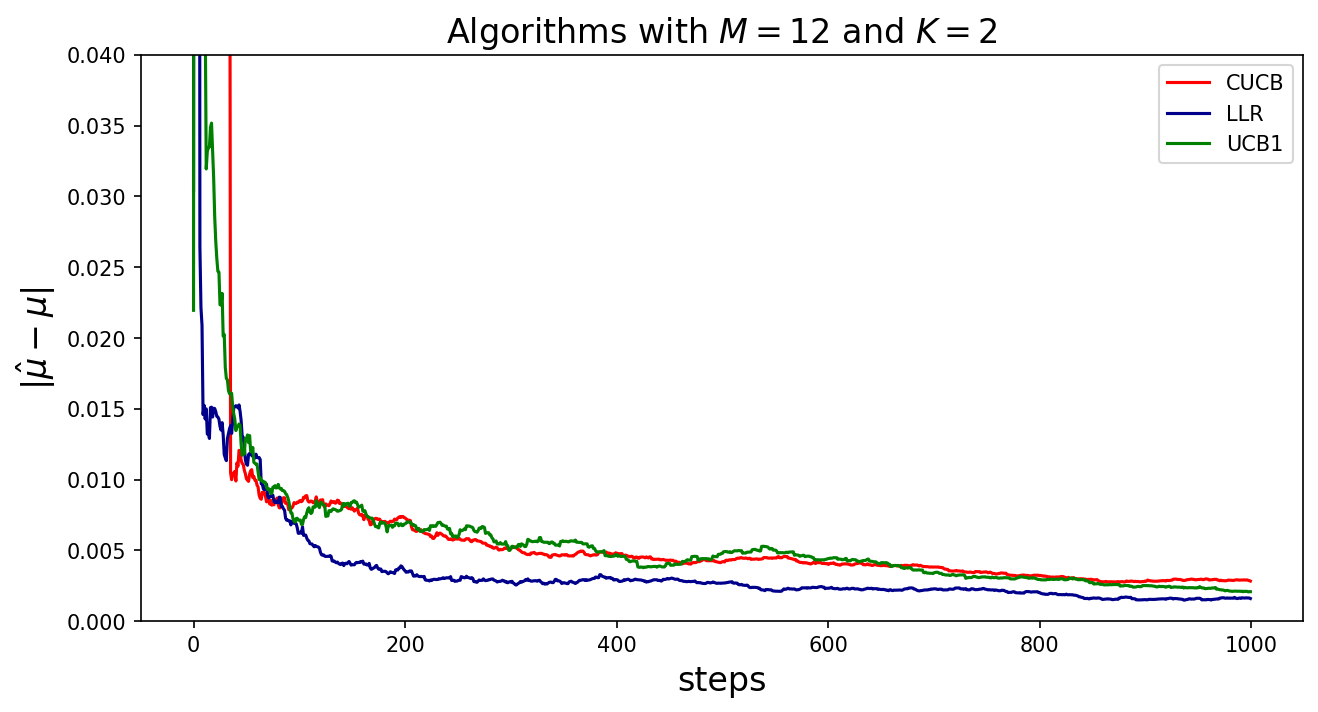

In [20]:
distances.plot(ylim=(0, .04), figsize=(10, 5), color=['red', 'darkblue', 'green'])
plt.title(r'Algorithms with $M = 12$ and $K=2$', fontsize=16);

plt.ylabel(r'$|\hat \mu - \mu|$', fontsize=16);
plt.xlabel(r'steps', fontsize=16);

plt.savefig('../../Outputs/Figures/figure_3_model_validation.png')

### Figure 4 Section Model Validation.
Number of visits (i.e., fired arms) of algorithms to each arm

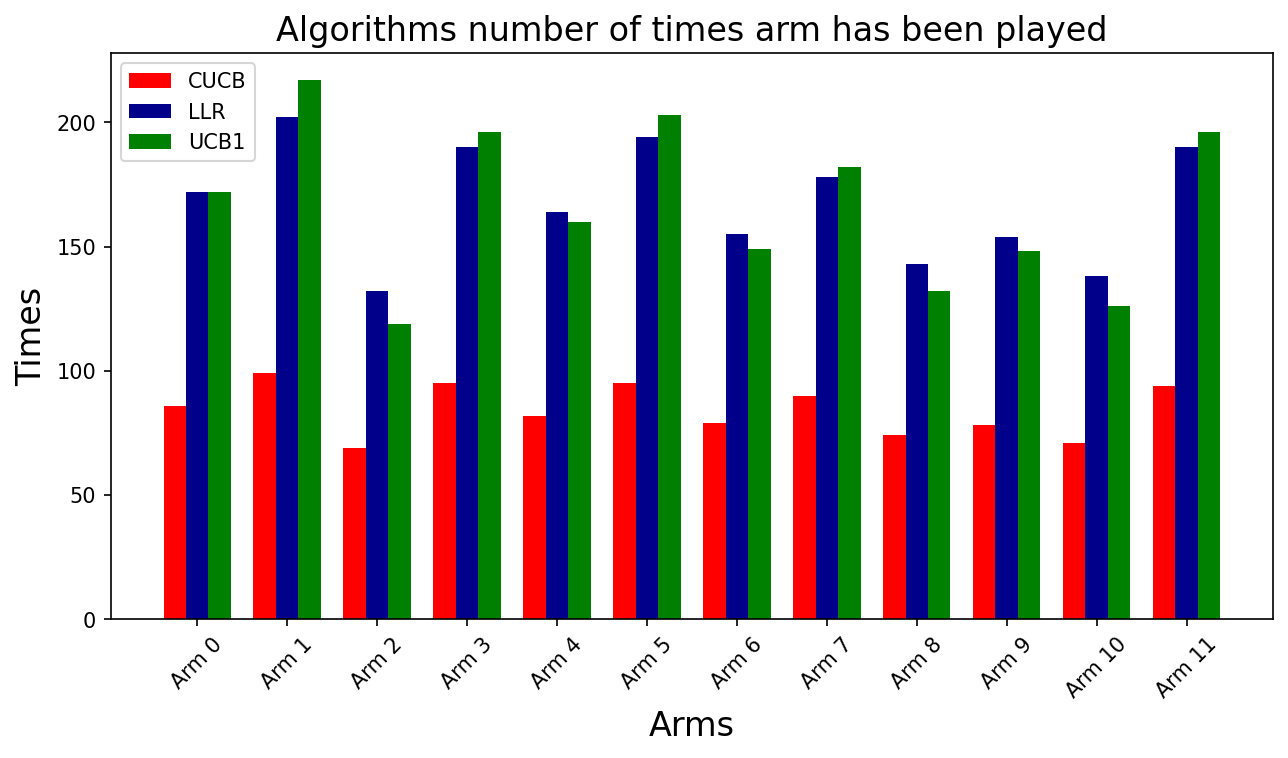

In [21]:
# heat_map_a.rename(columns={'Chen': 'CUCB'}, inplace=True)
plt.figure(figsize=(10, 5))

N = 12
ind = np.arange(N) 
width = 0.25
  
xvals = heat_map_a['UCB1'].values
bar1 = plt.bar(ind, xvals, width, color = 'red')
  
yvals = heat_map_a['LLR'].values
bar2 = plt.bar(ind+width, yvals, width, color='darkblue')
  
zvals = heat_map_a['CUCB'].values
bar3 = plt.bar(ind+width*2, zvals, width, color = 'green')
  
plt.xlabel("Arms", fontsize=16)
plt.ylabel('Times', fontsize=16)
plt.xticks(ind+width, heat_map_a.index, rotation=45)
plt.legend( (bar1, bar2, bar3), heat_map_a.columns )

plt.title('Algorithms number of times arm has been played', fontsize=16);

plt.savefig('../../Outputs/Figures/figure_4_model_validation.png')


### Figure 5 Section Model Validation.
Convergence error of true arms mean for each algorithm. The error is measured as the Euclidean distance between the true mean vector and estimated mean vector per round.

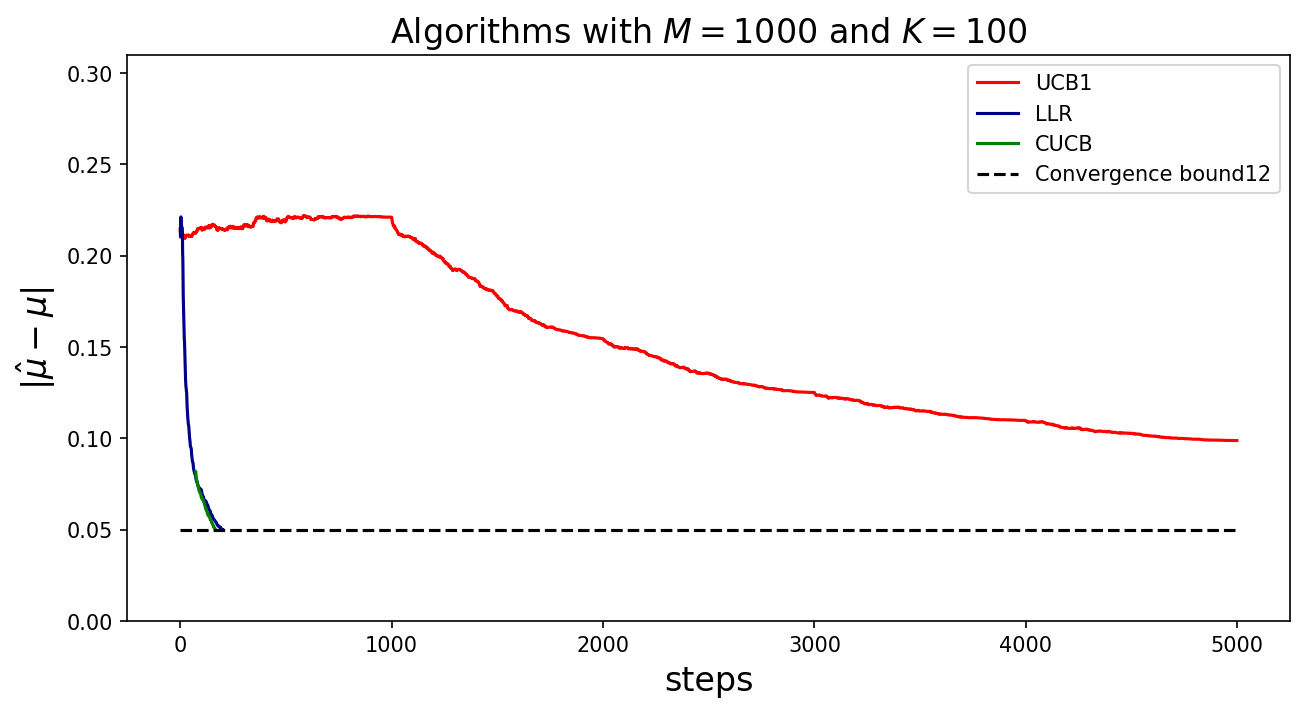

In [22]:
df = pd.read_csv('../../Data/distance_1000.csv').rename(columns={'Chen': 'CUCB'})
df['LLR'] = np.where(df['LLR'] > 1, np.nan, df['LLR'])
df['CUCB'] = np.where(df['CUCB'] > 1, np.nan, df['CUCB'])

df.plot(ylim=(0, .31), figsize=(10, 5), color=['red', 'darkblue', 'green'])

plt.hlines(y = .05, xmin = 0, xmax = 5000, label = "Convergence bound" + str(m + 1), linestyles = "dashed", colors='black')

plt.legend()

plt.title(r'Algorithms with $M = 1000$ and $K=100$', fontsize=16);
plt.ylabel(r'$|\hat \mu - \mu|$', fontsize=16);
plt.xlabel(r'steps', fontsize=16);

plt.savefig('../../Outputs/Figures/figure_5_model_validation.png')

### Figure 6 Section Model Validation.
Convergence error of true arms mean for each algorithm. The error is measured as the Euclidean distance between the true mean vector and estimated mean vector per round.

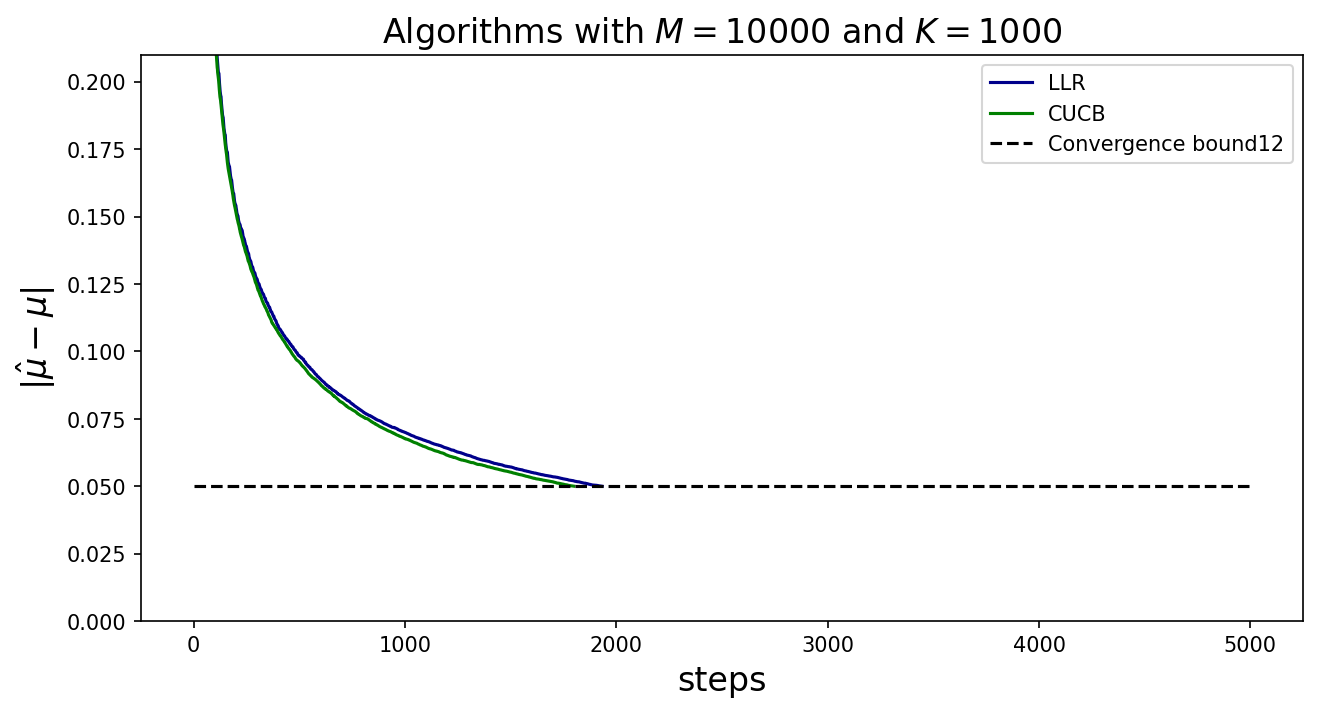

In [23]:
df = pd.read_csv('../../Data/distance_10000.csv').rename(columns={'Chen': 'CUCB'})
df['LLR'] = np.where(df['LLR'] > 1, np.nan, df['LLR'])
df['CUCB'] = np.where(df['CUCB'] > 1, np.nan, df['CUCB'])

df.plot(ylim=(0, .21), figsize=(10, 5), color=['darkblue', 'green'])

plt.hlines(y = .05, xmin = 0, xmax = 5000, label = "Convergence bound" + str(m + 1), linestyles = "dashed", colors='black')

plt.legend()

plt.title(r'Algorithms with $M = 10000$ and $K=1000$', fontsize=16);
plt.ylabel(r'$|\hat \mu - \mu|$', fontsize=16);
plt.xlabel(r'steps', fontsize=16);

plt.savefig('../../Outputs/Figures/figure_6_model_validation.png')

### Figure 7 Section Model Validation.
Convergence error of true arms mean for each algorithm. The error is measured as the Euclidean distance between the true mean vector and estimated mean vector per round.

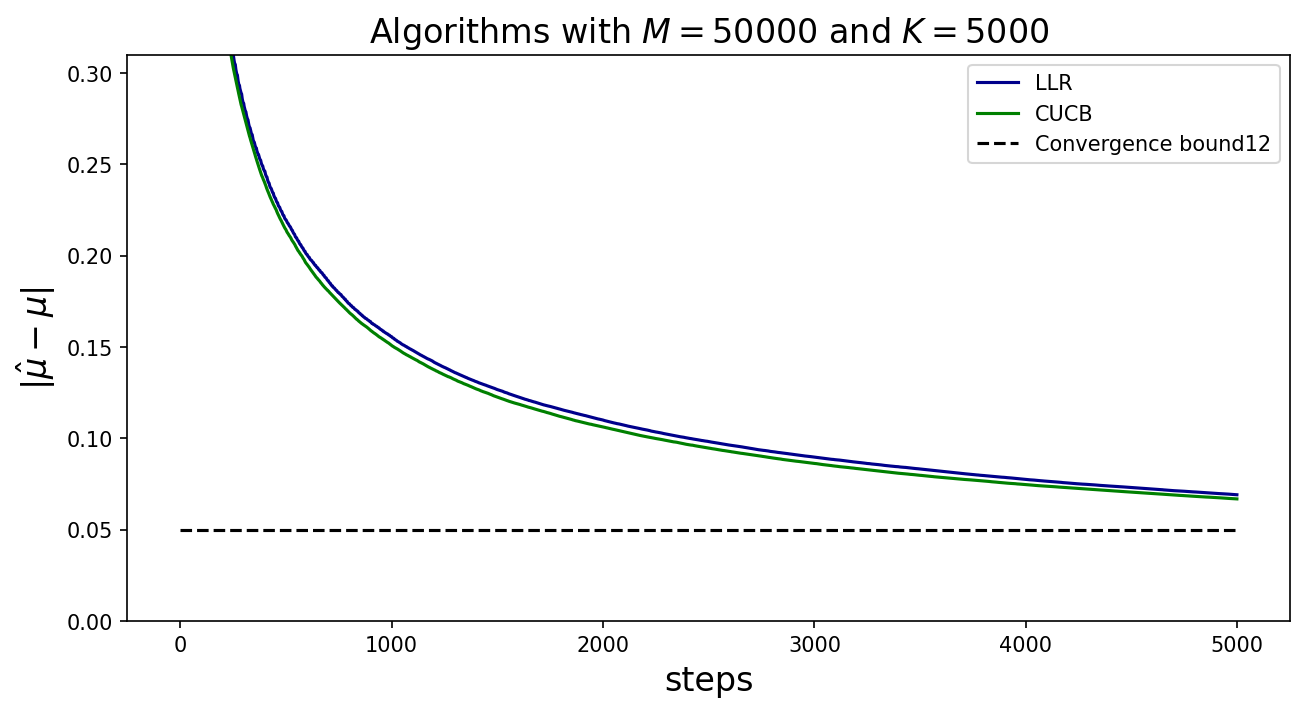

In [24]:
df = pd.read_csv('../../Data/distance_50000.csv').rename(columns={'Chen': 'CUCB'})
df['LLR'] = np.where(df['LLR'] > 1, np.nan, df['LLR'])
df['CUCB'] = np.where(df['CUCB'] > 1, np.nan, df['CUCB'])

df.plot(ylim=(0, .31), figsize=(10, 5), color=['darkblue', 'green'])

plt.hlines(y = .05, xmin = 0, xmax = 5000, label = "Convergence bound" + str(m + 1), linestyles = "dashed", colors='black')

plt.legend()

plt.title(r'Algorithms with $M = 50000$ and $K=5000$', fontsize=16);
plt.ylabel(r'$|\hat \mu - \mu|$', fontsize=16);
plt.xlabel(r'steps', fontsize=16);

plt.savefig('../../Outputs/Figures/figure_7_model_validation.png')
